# Laboratory 2.1: Graph Neural Networks (GNNs)

**Objectives:** 

- Implement a data-driven model based on graph neural networks (GNN) to estimate the pressures at the nodes of a water distribution system.
- Analyse the training performance of the implemented GNN.
- Evaluate the execution performance of the data-driven model to emulate nodal pressures.
- Transfer the developed data-driven model to a new case study.

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - defining a GNN-model. 
  - training the GNN-model
  - assesing the performance of the GNN-model.
  - transfering and assesing the GNN-model.
- Answered the analysis questions on each section. 

## 🔙 Background

Water utilities rely on hydrodynamic models to properly design and control water distribution systems (WDSs). These physically-based models, such as [EPANET](https://www.epa.gov/water-research/epanet), compute the state of the system, i.e., the flow rates and pressures at all the pipes and junctions, as illustrated in Figure 1. 

<center><figure>

  <img src="https://drive.google.com/uc?id=1D1yRrUTEbBRbEWNeyn1ibGJ23n8FQ90a" width=600/>
<figcaption>Figure 1. EPANET results in WDS in Fossolo, Italy. 

<sub><sup> Pressure and flows are presented with different color schemes. </sup></sub></figcaption>

</figure></center>

Hydrodynamic models provide valuable insight into the functioning of the system. However, the computational speed of these models is often insufficient for some applications in civil engineering such as optimisation of design or criticality assessment, especially in large search space problems. 

One alternative to address this issue is developing data-driven models. These models are trained using results calculated using the original model (EPANET, in this case) in multiple scenarios. The objective of the data-driven models is to estimate the output of the original model but in a shorter time.

## ⛔ Problem definition 

As part of a re-design of the Fossolo WDS, the water utility company has decided to use an optimisation approach. Aware that the established optimisation algorithms for designing water systems require a large number of scenarios, the company has decided to create a data-driven model to accelerate the process. 

From a graph machine learning perspective, this problem can be framed as a node regression. This is, given the network topology and input features at the nodes and/or edges, we want to use a GNN-model to infer the value of a variable at each node.

<center><figure>

  <img src="https://drive.google.com/uc?id=1HKOReaYv8KJMA0jkPfziSWbmDPIDc8Nw" width=600/>
<figcaption>Figure 2. Representation of water network as a graph. 

</figure></center>


As a consultant for the water utility, your task is to develop a GNN-based tool that can perform pressure estimation at the nodes. This system will process different configurations of network characteristics (e.g., pipe diameters, nodal demands, type of nodes), and estimate the pressure at each node of the system. 

This tool is developed in a _supervised learning_ manner by employing the scenarios datasets already prepared by the company. 


## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- NetworkX
- Scikit-learn
- Pytorch
- Pytorch geometric

In [1]:
import time
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.loader import DataLoader as pyg_DataLoader

## 📚 Database

The Fossolo water network has 37 nodes and 58 pipes. The network is represented as an undirected graph; this means that each pipe is represented as 2 edges, one incoming and one outgoing. In summary, each graph has 37 nodes and 116 edges.

For this WDS, we already have a database with 1000 scenarios. This database was created by generating multiple combinations of diameters at the pipes and water consumption at the nodes. 

The dataset was created using a Python package, based on EPANET, designed to simulate the behaviour of water distribution networks. Each scenario is represented as a [Data object](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) that contains edge features, node features, and the target feature. All of the features are already normalized based on a min-max scaling.

The diameter at the pipes is the only edge feature. The node features consist of water consumption, node_type (0 for junction and 1 for reservoirs), junction elevation, and reservoir elevation. 

*Run the following cell to load the datasets from the pickle files.*

In [2]:
with open('Training_dataset_WDS.p', 'rb') as handle:
    tra_dataset_pyg = pickle.load(handle)
with open('Validation_dataset_WDS.p', 'rb') as handle:
    val_dataset_pyg = pickle.load(handle)
with open('Test_dataset_WDS.p', 'rb') as handle:
    tst_dataset_pyg = pickle.load(handle)

In [3]:
print('Number of training examples:',   len(tra_dataset_pyg))
print('Number of validation examples:', len(val_dataset_pyg))
print('Number of test examples:',       len(tst_dataset_pyg))

Number of training examples: 750
Number of validation examples: 125
Number of test examples: 125


We can inspect the content of one example:

In [4]:
tra_dataset_pyg[0]

Data(x=[37, 4], edge_attr=[116, 1], edge_index=[2, 116], y=[37, 1])

Each example in the database contains the following information:
- **x:** Input node features with shape [Nodes, Node features]. This matrix is composed of 4 normalized variables for each node. Namely,
  - Normalized water consumption. Original values between 0 and 0.007 cubic meters per second.
  - Normalized junction elevation. Original values between 0 and 67.9 m.
  - Normalized reservoir elevation. Original values between 0 and 121 m.
  - One-hot encoding for type of node (1 for reservoir, 0 for junction)

- **edge_attr:** Input edge features with shape [Edges, Edge features]. This matrix is composed of 1 normalized variable for each pipe. Namely,
  - Normalized diameter. Original values between 0.025 and 0.4750.

- **edge_index:** Graph connectivity in COO format with shape [2, num_edges]

- **y:** Output node feature, i.e. target feature. Shape [Nodes, 1]. Original values between 0 and 59.56 mH2O.

## 💻 GNN training

**Instructions:**
Define a GNN model class, instantiate it, and train it.

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>
Imagine you are tasked with solving this problem using a GNN model.
*   What dimensions do the inputs and outputs have?
*   Which methods/architectures would you try first and why? (More than correctness, think of plausible components to test based on the problem description.)
*   What hyperparameters define the structure of the model?

Write your answers in the following cell

#### Answers:
<font color='289C4E'><font>
*   What dimensions do the inputs and outputs have?
<font color='white'><font>

    - Node features (x): matrix of shape [37, 4], which corresponds to 37 nodes in the system and 4 features for each node. 

    - Edge features (edge_attr): matrix of shape [116, 1] that corresponds to 116 edges or pipes and 1 feature, the diameter of each pipe.

    - Edge index (edge_index):  matrix of shape [2, 116] that represents the connectivity of the graph.

    - Output node features (y):  target variable to predict, matrix of shape [37, 1], corresponding to 37 nodes in the system and the pressure value at each node.


<font color='289C4E'><font>
*   Which methods/architectures would you try first and why? (More than correctness, think of plausible components to test based on the problem description.)
<font color='white'><font>

     The task is node regression to estimate the pressure at each node given a particular configuration of pipe diameters and water consumption at the nodes.  I would first try to use a Graph Convolutional Network  since it is one of the simplest yet powerful GNN architectures operating over nodes and their direct neighbors, which seems suitable for this problem.  Another option are Graph Attention Networks since they assign weights, focusing more on the important neighbors. This might be useful if certain nodes. for example the water reservoirs, have a bigger impact on the pressures at given nodes.  There are many other complex architectures can be tried but those two make a good starting point. 

<font color='289C4E'><font>
*   What hyperparameters define the structure of the model?
<font color='white'><font>

    Many of the hyperparameters that define the structure of the model are similar to those of a traditional neural network. The number of layers, number of hidden units, input and output dimensions, learning rate, batch size, dropout rate, weight decay, activation function, type of aggregation function, number of epochs, and the number of hops in the neighbourhood for each layer.



---

### Model definition - Example

Below follows an example of a GNN model. You can use this code as a template for your own GNN model. 

In [5]:
class GNN_Example(nn.Module):
  """
    This class defines a PyTorch module that takes in a graph represented in the PyTorch Geometric Data format,
    and outputs a tensor of predictions for each node in the graph. The model consists of one or more TAGConv layers,
    which are a type of graph convolutional layer.

    Args:
        node_dim (int): The number of node inputs.
        edge_dim (int): The number of edge inputs.
        output_dim (int, optional): The number of outputs (default: 1).
        hidden_dim (int, optional): The number of hidden units in each GNN layer (default: 50).
        n_gnn_layers (int, optional): The number of GNN layers in the model (default: 1).
        K (int, optional): The number of hops in the neighbourhood for each GNN layer (default: 2).
        dropout_rate (float, optional): The dropout rate to be applied to the output of each GNN layer (default: 0).

    """
  def __init__(self, node_dim, edge_dim, output_dim=1, hidden_dim=50, n_gnn_layers=1, K=2, dropout_rate=0):
    super().__init__()
    self.node_dim = node_dim          
    self.edge_dim = edge_dim          
    self.output_dim = output_dim      
    self.hidden_dim = hidden_dim      
    self.n_gnn_layers = n_gnn_layers  
    self.K = K                        
    self.dropout_rate = dropout_rate
    
    self.convs = nn.ModuleList()

    if n_gnn_layers == 1:
      self.convs.append(TAGConv(node_dim, output_dim, K=K))
    else:
      self.convs.append(TAGConv(node_dim, hidden_dim, K=K))

      for l in range(n_gnn_layers-2):
          self.convs.append(TAGConv(hidden_dim, hidden_dim, K=K))
          
      self.convs.append(TAGConv(hidden_dim, output_dim, K=K))

  def forward(self, data):
      """Applies the GNN to the input graph.

        Args:
            data (Data): A PyTorch Geometric Data object representing the input graph.

        Returns:
            torch.Tensor: The output tensor of the GNN.

        """
      x = data.x
      edge_index = data.edge_index
      edge_attr = data.edge_attr
      
      for i in range(len(self.convs)-1):
          x = self.convs[i](x=x, edge_index=edge_index, edge_weight=edge_attr)
          x = nn.Dropout(self.dropout_rate, inplace=False)(x)
          x = nn.PReLU()(x)
      
      x = self.convs[-1](x=x, edge_index=edge_index, edge_weight=edge_attr)
      # x = nn.Sigmoid()(x)
      
      return x

#### Model instantiation

In [6]:
# Set model parameters
node_dim =   tra_dataset_pyg[0].x.shape[1]
edge_dim =   tra_dataset_pyg[0].edge_attr.shape[1]
output_dim = tra_dataset_pyg[0].y.shape[1]
hidden_dim = 16
n_gnn_layers = 3
K=1
dropout_rate = 0

# Create model
model = GNN_Example(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate)
print(model)

GNN_Example(
  (convs): ModuleList(
    (0): TAGConv(4, 16, K=1)
    (1): TAGConv(16, 16, K=1)
    (2): TAGConv(16, 1, K=1)
  )
)


### Define your own GNN

In the following cells, define and instatiate your own GNN model. You can use already implemented layers from [Pytorch Geometric library](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html). 

In [7]:
from torch_geometric.nn import GCNConv

class My_GNN(nn.Module):
    def __init__(self, node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, dropout_rate):
        super(My_GNN, self).__init__()

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(node_dim, hidden_dim))

        for _ in range(n_gnn_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = nn.ReLU()(x)
            x = self.dropout(x)
            
        x = self.convs[-1](x, edge_index)

        return x


In [8]:
# Set model parameters
node_dim =   tra_dataset_pyg[0].x.shape[1]
edge_dim =   tra_dataset_pyg[0].edge_attr.shape[1]
output_dim = tra_dataset_pyg[0].y.shape[1]
hidden_dim = 16
n_gnn_layers = 3
K=1 
dropout_rate = 0

# Create model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = My_GNN(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, dropout_rate)
model = model.to(device)
print(model)

My_GNN(
  (convs): ModuleList(
    (0): GCNConv(4, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 1)
  )
  (dropout): Dropout(p=0, inplace=False)
)


### 🏋🏽‍♀️Train a Graph Neural Network

Train your GNN model. 

_Recommendations for first trial_
- Use dropout and early stopping to reduce overfitting
- Use the Adam optimizer, and set learning rate to 0.001
- Use a batch size of 16

#### Training epoch function

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, device=device):
    """
        Trains a neural network model for one epoch using the specified data loader and optimizer.

        Args:
            model (nn.Module): The neural network model to be trained.
            loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
            optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
            device (str): The device used for training the model (default: 'cpu').

        Returns:
            float: The mean loss value over all the batches in the DataLoader.

        """
  
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device) 
        optimizer.zero_grad() 

        # Forward pass
        out = model(batch) 
        loss = nn.MSELoss()(out, batch.y) 

        # Backward pass
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

#### Testing epoch function

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def evaluate_epoch(model, loader, device=device):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device) 

            # Forward pass
            out = model(batch) 
            loss = nn.MSELoss()(out, batch.y) 

            total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

#### Optimization of the Model

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
# Set training parameters
learning_rate = 0.001
batch_size = 16
num_epochs = 100

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the GNN in batches
tra_loader = pyg_DataLoader(tra_dataset_pyg, batch_size=batch_size, shuffle=True)
val_loader = pyg_DataLoader(val_dataset_pyg, batch_size=batch_size, shuffle=False)

In [13]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
patience = 5       # patience for early stopping

#start measuring time
start_time = time.time()

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, tra_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluate_epoch(model, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping
    try:
        if val_losses[-1]>=val_losses[-2]:
            early_stop += 1
            if early_stop == patience:
                print("Early stopping! Epoch:", epoch)
                break
        else:
            early_stop = 0
    except:
        early_stop = 0

    if epoch%10 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))

elapsed_time = time.time() - start_time
print(f'Model training took {elapsed_time:.3f} seconds')

epoch: 10 	 training loss: 0.0138 	 validation loss: 0.0093
epoch: 20 	 training loss: 0.0132 	 validation loss: 0.0088
epoch: 30 	 training loss: 0.0125 	 validation loss: 0.0082
epoch: 40 	 training loss: 0.0122 	 validation loss: 0.0078
epoch: 50 	 training loss: 0.0121 	 validation loss: 0.0076
epoch: 60 	 training loss: 0.0117 	 validation loss: 0.0073
epoch: 70 	 training loss: 0.0119 	 validation loss: 0.0073
epoch: 80 	 training loss: 0.0114 	 validation loss: 0.0073
epoch: 90 	 training loss: 0.0114 	 validation loss: 0.007
epoch: 100 	 training loss: 0.0113 	 validation loss: 0.0086
Model training took 29.060 seconds


In the following cell, plot the loss as function of epochs

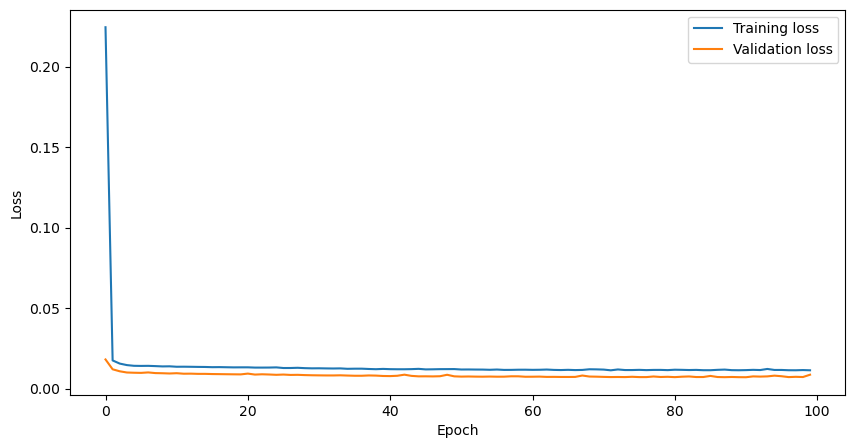

In [14]:
# plot the training and validation loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the loss curves:
*   What would you conclude about the overfitting or underfitting capabilities of the model?
*   Is this model adequate to be used? Why?

#### Answers:

Comparing the training and validation loss curves, we can see that the validation loss is lower than the training loss, which indicates that the model is not overfitting. It would be overfitting if the training loss continued to decrease with the epochs while the validation loss started to increase. The model is not underfitting either since both losses are relatively low. However, the model is not very adequate because the losses do not improve much after the first epochs. 



## 📈 Results

For our application, we need the model to be both accurate and fast. Here, we will test those qualities.

### Accuracy

#### Loss

Calculate the loss value for the test dataset

In [15]:
tst_loader = pyg_DataLoader(tst_dataset_pyg, batch_size=batch_size, shuffle=False) 
tst_loss = evaluate_epoch(model, tst_loader, device=device)
num_test_sims = len(tst_dataset_pyg)

print('Test loss: ', tst_loss)
print('Number of test scenarios: ', num_test_sims)

Test loss:  0.016464490115642546
Number of test scenarios:  125


### Errors in unnormalized variable

Calculate the error in pressure for all the nodes in all the scenarios. This error matrix should be of shape [Scenarios , Nodes].

Remember that the variables were normalized for training purposes. However, the water utility is interested in the value of the output variable in physical units, in this case, pressure in mH2O. In order to do this, unnormalize the output variable knowing that the maximum and minimum pressures used to normalized the output variable were 59.56 mH2O and 0 mH2O, respectively.

In [39]:
max_pressure = 59.56 #mH2O

def predict_model(model, data, device=device):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        output = model(data)
    return output

# Initialize error matrix
num_test_sims = len(tst_dataset_pyg)
num_nodes = 37
error = np.zeros((num_test_sims, num_nodes))


for i, scenario in enumerate(tst_dataset_pyg):

    estimated_pressure_normalized = predict_model(model, scenario)

    # Unnormalize the pressures
    estimated_pressure = estimated_pressure_normalized.to('cpu') * max_pressure
    target_pressure = scenario.y.to('cpu') * max_pressure

    # Compute the error
    error_difference  = estimated_pressure.detach().numpy() - target_pressure.detach().numpy()
    error[i] = error_difference.flatten()

In [40]:
print(error.shape)

(125, 37)


#### Error in pressure for all scenarios for one node

Plot the error of one node across test scenarios. 

In [41]:
node_ID = 15
error_node = error[:, node_ID]

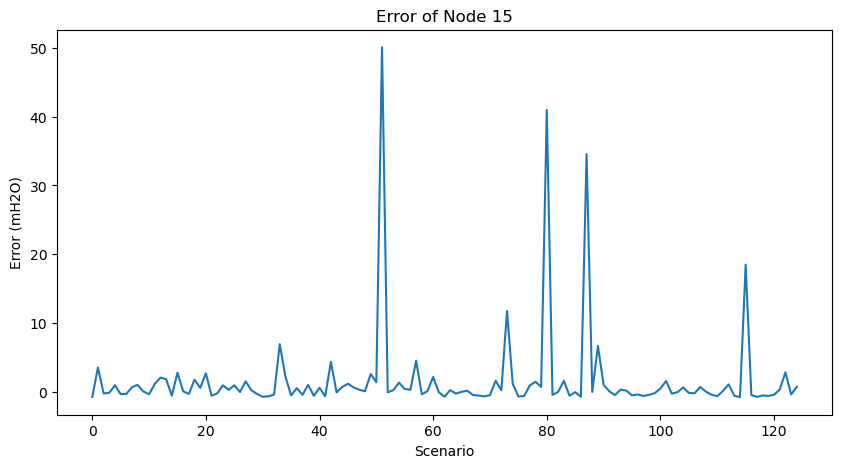

In [42]:
# Plot the error of a single node across test scenarios.
plt.figure(figsize=(10,5))
plt.plot(error_node)
plt.title('Error of Node {}'.format(node_ID))
plt.xlabel('Scenario')
plt.ylabel('Error (mH2O)')
plt.show()


### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results accross scenarios:
*   Is the model satisfactorily fitting? 
*   If there are there outliers, do they have any pattern? 
*   Are these errors considerable?



#### Answers:

The error across most of the nodes is low, which indicates that the model is fitting well. However, there are some outliers for which the model is not able to accurately predict the pressures, leading to large errors. I suspect they might be nodes related to the reservoirs. The errors are very considerable for those nodes which would hinder the adoption of the model for real-world applications.





#### Error of all nodes in one scenario

Plot the error of all the nodes of one scenario. 

In [48]:
sce_ID = 10
error_sim = error[sce_ID, :]

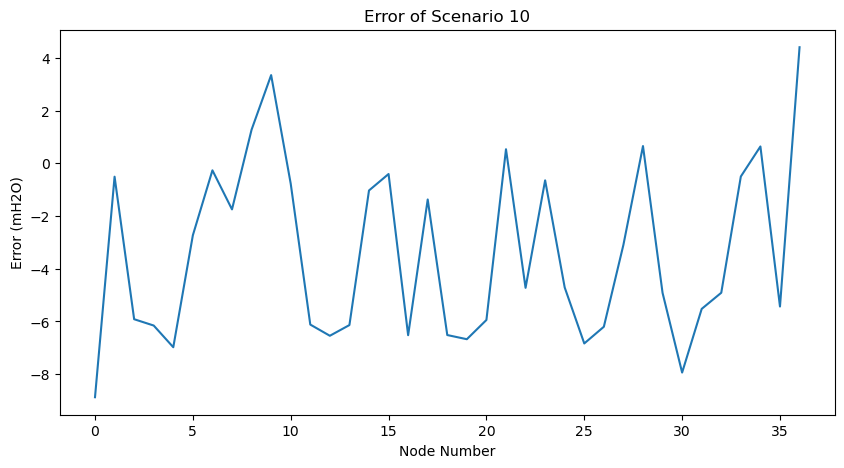

In [49]:
#Plot the error for all the nodes in one single scenario.
plt.figure(figsize=(10,5))
plt.plot(error_sim)
plt.title('Error of Scenario {}'.format(sce_ID))
plt.xlabel('Node Number')
plt.ylabel('Error (mH2O)')
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on this error analysis:
*   How does it compare with the previous error analysis?
*   Is the model over- or under- predicting?
*   Would you recommend the water utility to use this model?
    *   Does your recommendation match with your previous recommendation?

    

#### Answers:

The graphs plots the error for all the nodes in one scenario. The error varies significantly from node to node, being negative in most cases meaning that the model is predicting lower pressures than those used as labels. The error for the fist and last node is the greatest in this specific scenario. My recommendation to the water utility would depend on the intended use of the model, if only a rough overview of the water network is required, the model might be useful. However, if the model is intended to be used for more detailed analysis, I would not recommend it because the errors are too large in some cases. 

### Speed

We can calculate the time per scenario that the model takes.

In [54]:
start_time = time.time()
  #Execute the model here for all the simulations in the test case
for example in tst_dataset_pyg:
  example = example.to(device)
  output = model(example)
total_time = time.time() - start_time

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.5f} seconds for {num_test_sims} scenarios')

Data-driven model took 0.00214 seconds for 125 scenarios


Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)

In [55]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

The data-driven model is 18.72 times faster than EPANET per scenario.


### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on speed:
*   Which factors or components could make the model faster or slower on its execution?


#### Answers:

The model is quite fast, much faster than the EPANET simulation. The speed of the model could be further improved by simplifying the model architecture, reducing the number of layers and hidden units. It could also be achieved by making use of faster hardware or by simpliyfing the graph structure. On the contrary, making use of a more complex model architecture would slow down the model but it could also improve the accuracy of the predictions.





## 🥈 Transferability

A practical property of graph neural networks is their independence of the domain in which they are trained on. Therefore, they can be (pre-)trained in one network and be used in another case. Let's explore this property by using the already trained models on another water distribution network. 

This water network comes from the city of Pescara. This network has 71 nodes (68 junctions and 3 reservoirs) and 196 edges (98 pipes).

<center><figure>

  <img src="https://drive.google.com/uc?id=1tpuaoC1Ij3AdAt1zthtft5Lk2vMfq4d3" width=600/>
<figcaption>Figure 3. EPANET results in WDS in Pescara, Italy. 

<sub><sup> Pressure and flows are presented with different color schemes. </sup></sub></figcaption>

</figure></center>

There is already a prepared scenario example from this network. This example has been already normalized. The "y" values were normalized considering a minimum of 0 mH2O and a maximum of 51.75 mH2O. 

Let's load this scenario and use our model to estimate the pressure at all nodes.

In [56]:
with open("PES_example.p", 'rb') as handle:
    pes_data = pickle.load(handle)

Use your model to estimate the pressure for this scenario on this new network.

In [61]:
max_pressure_pes = 51.75  # mH2O
predictions = model(pes_data.to(device))
predictions = predictions.to('cpu') * max_pressure_pes

Estimate the difference (in meters) between the actual pressure and the model.

In [63]:
unnormalized_pressure = pes_data.y.to('cpu') * max_pressure_pes
error = predictions.detach().numpy() - unnormalized_pressure.detach().numpy()

In [65]:
error.shape

(71, 1)

Plot the error of all the nodes for this scenario. 

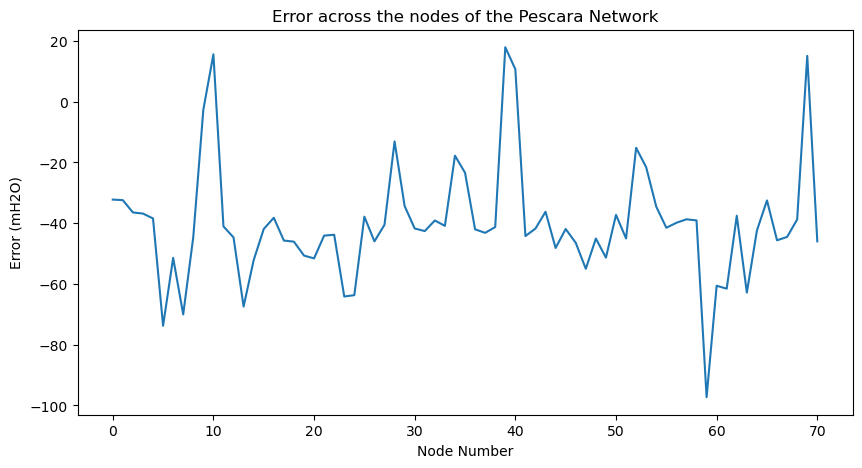

In [68]:
# Plot the error for all the nodes in this new water network.
plt.figure(figsize=(10,5))
plt.plot(error)
plt.title('Error across the nodes of the Pescara Network')
plt.xlabel('Node Number')
plt.ylabel('Error (mH2O)')
plt.show()

### 🕵 <font color='289C4E'>Questions<font><a class='anchor' id='top'></a>

Based on the results on transferability:
*   How does this error distribution compare against the error distribution for the previous network?
*   Which factors do you consider influence the performance of the model when it is transferred?
*   How do you consider the model could improve its transfer capability?

#### Answers:

The magnitude of the error is significantly higher on the Pescara network than in the network it was trained in, indicating poor transferibility capabilities of the model. The reason for it could be that the networks are too different from each other, as an example having twice the number of nodes. Furthermore, even if the graph topographies in both networks were very similar, it could be the case that the water consumption habits in both cities are very different, difficulting the transfer of the predictions. The model could improve its transfer capability by training with a diverse dataset, including networks from different cities. The use of a more complex model architecture could also improve the transferibility of the model, but it would be important to avoid overfitting.


